In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

In [2]:
df = pd.read_csv("Input_3.csv")
df.drop(columns=['Unnamed: 0'],axis=1,inplace=True)

C:\Users\rizar\AppData\Local\Temp\ipykernel_31312\1650399802.py:1: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("Input_3.csv")


In [3]:
df.head()

,id,member_id,loan_amnt,int_rate,emp_length,home_ownership,annual_inc,purpose,zip_code,addr_state,...,risk_category,monthlydebtperincome,quartile_debt,remaining_payment,income_higher,term_36 months,term_60 months,emp_length_numeric,age,age_group
0,1077430,1314167,2500,15.27,< 1 year,RENT,30000.0,car,309xx,GA,...,Low Risk,0.016667,0.050000,2339629.0,0,0,1,0,21,0
1,1075358,1311748,3000,12.69,1 year,RENT,80000.0,other,972xx,OR,...,No Risk,0.007500,0.022500,2139983.0,1,0,1,1,22,0
2,1069639,1304742,7000,15.96,8 years,RENT,47004.0,debt_consolidation,280xx,NC,...,Low Risk,0.029785,0.089354,6309516.0,0,0,1,8,29,2
3,1071795,1306957,5600,21.28,4 years,OWN,40000.0,small_business,958xx,CA,...,No Risk,0.028000,0.084000,7421478.0,0,0,1,4,25,1
4,1071570,1306721,5375,12.69,< 1 year,RENT,15000.0,other,774xx,TX,...,Low Risk,0.071667,0.215000,4267406.0,0,0,1,0,21,0


In [4]:
df.shape

(569709, 33)

In [5]:
df.columns

Index(['id', 'member_id', 'loan_amnt', 'int_rate', 'emp_length',
       'home_ownership', 'annual_inc', 'purpose', 'zip_code', 'addr_state',
       'total_pymnt', 'total_rec_int', 'default_ind', 'state_avg_inc',
       'total_payment', 'term_nums', 'emp_length_nums', 'monthly_income',
       'home_ownership_encoded', 'income_to_loan',
       'income_to_loan_ratio_percentage', 'asset_to_loan_ratio', 'risk_status',
       'risk_category', 'monthlydebtperincome', 'quartile_debt',
       'remaining_payment', 'income_higher', 'term_36 months',
       'term_60 months', 'emp_length_numeric', 'age', 'age_group'],
      dtype='object')

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

# Feature selection
features = [
    "loan_amnt", "int_rate", "monthly_income", "total_payment", "total_rec_int",
    "quartile_debt", "remaining_payment"
]
target = "default_ind"

# Split data into features and target
X = df[features]
y = df[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [7]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.pipeline import Pipeline as ImbPipeline

# Scaling
scaler = StandardScaler()

# Fit on the training data and transform both training and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create ADASYN object
adasyn = ADASYN(random_state=42)

# Resample training data
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train_scaled, y_train)

# Print class distributions
print(f"Before adasyn - y_train counts:\n{y_train.value_counts()}")
print(f"After adasyn - y_train_adasyn counts:\n{pd.Series(y_train_adasyn).value_counts()}")

Before adasyn - y_train counts:
default_ind
0    428931
1     26836
Name: count, dtype: int64
After adasyn - y_train_adasyn counts:
default_ind
1    430742
0    428931
Name: count, dtype: int64


Evaluating XGBoost
Best XGBoost Accuracy: 0.7226220357725861
Best XGBoost ROC-AUC: 0.9050993572590185
[[76374 30859]
 [  746  5963]]
              precision    recall  f1-score   support

           0       0.99      0.71      0.83    107233
           1       0.16      0.89      0.27      6709

    accuracy                           0.72    113942
   macro avg       0.58      0.80      0.55    113942
weighted avg       0.94      0.72      0.80    113942



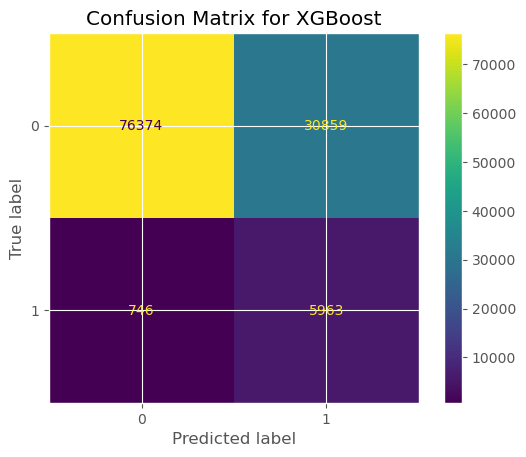

In [12]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import (
    roc_auc_score, confusion_matrix, classification_report, accuracy_score,
    ConfusionMatrixDisplay, precision_score, recall_score, f1_score
)
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Set up the models
models = {
    "XGBoost": XGBClassifier(tree_method='hist', random_state=42)
}

# Define hyperparameters for tuning
param_grids = {
    "XGBoost": {
        "n_estimators": [50, 100, 200],
        "max_depth": [3, 6, 10],
        "learning_rate": [0.01, 0.05, 0.1],
        "subsample": [0.7, 1.0],
        "max_delta_step": [0, 1, 5, 10],  
        "scale_pos_weight": [1, 5, 10, 15], 
        "lambda": [0, 0.1, 1, 10], 
        "alpha": [0, 0.1, 1, 5],
    }
}

# Set up RandomizedSearchCV and tune each model
best_models = {}
for model_name in models:
    random_search = RandomizedSearchCV(
        estimator=models[model_name],
        param_distributions=param_grids[model_name],
        n_iter=10,  
        cv=3,       
        scoring='roc_auc',
        n_jobs=-1,
        random_state=42,
        error_score='raise'
    )
    random_search.fit(X_train_adasyn, y_train_adasyn) 
    best_models[model_name] = random_search.best_estimator_

# Evaluate the models
for model_name, model in best_models.items():
    print(f"Evaluating {model_name}")
    
    # Get predictions and probabilities
    y_pred = model.predict(X_test_scaled)
    y_probs = model.predict_proba(X_test_scaled)[:, 1]

    # Calculate and print Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Best {model_name} Accuracy: {accuracy}")

    # Calculate and print ROC-AUC
    roc_auc = roc_auc_score(y_test, y_probs)
    print(f"Best {model_name} ROC-AUC: {roc_auc}")

    # Print confusion matrix and classification report
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()
    plt.title(f"Confusion Matrix for {model_name}")
    plt.show()

Performing Threshold Analysis
   Threshold  Precision    Recall  F1-Score
0        0.1   0.079448  0.981666  0.146999
1        0.2   0.096121  0.960054  0.174747
2        0.3   0.114341  0.942167  0.203933
3        0.4   0.135818  0.920256  0.236701
4        0.5   0.161941  0.888806  0.273966
5        0.6   0.196773  0.852586  0.319750
6        0.7   0.249598  0.810553  0.381668
7        0.8   0.335767  0.740349  0.462004
8        0.9   0.508583  0.613802  0.556261


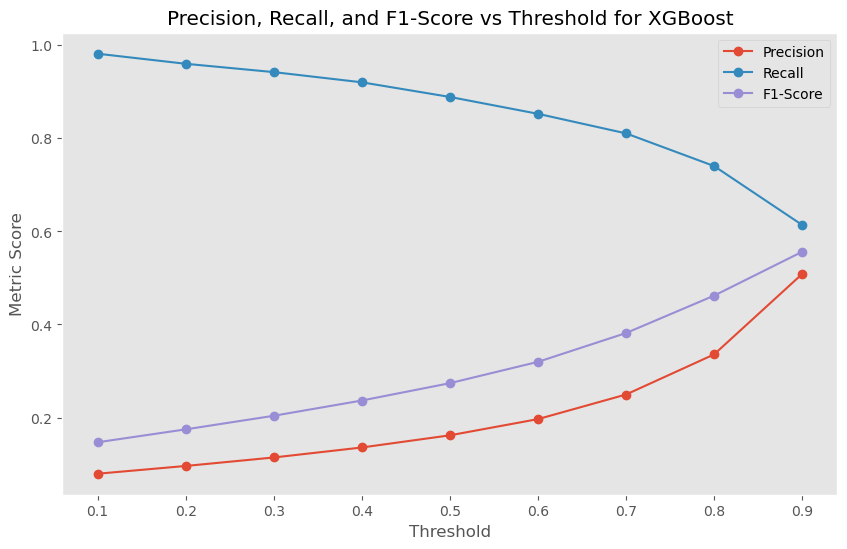

In [13]:
# Threshold Analysis
print("Performing Threshold Analysis")
thresholds = np.arange(0.1, 1.0, 0.1)
results = []

for threshold in thresholds:
    y_pred_threshold = (y_probs >= threshold).astype(int)
    precision = precision_score(y_test, y_pred_threshold)
    recall = recall_score(y_test, y_pred_threshold)
    f1 = f1_score(y_test, y_pred_threshold)

    results.append({
        "Threshold": threshold,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1
        })

# Convert results to DataFrame
results_df = pd.DataFrame(results)
print(results_df)

# Plot Threshold Analysis
plt.figure(figsize=(10, 6))
plt.plot(results_df["Threshold"], results_df["Precision"], label="Precision", marker='o')
plt.plot(results_df["Threshold"], results_df["Recall"], label="Recall", marker='o')
plt.plot(results_df["Threshold"], results_df["F1-Score"], label="F1-Score", marker='o')

plt.xlabel("Threshold")
plt.ylabel("Metric Score")
plt.title(f"Precision, Recall, and F1-Score vs Threshold for {model_name}")
plt.legend()
plt.grid()
plt.show()

Evaluating XGBoost
Best XGBoost Accuracy: 0.7864000982956241
Best XGBoost ROC-AUC: 0.9050993572590185
[[83884 23349]
 [  989  5720]]
              precision    recall  f1-score   support

           0       0.99      0.78      0.87    107233
           1       0.20      0.85      0.32      6709

    accuracy                           0.79    113942
   macro avg       0.59      0.82      0.60    113942
weighted avg       0.94      0.79      0.84    113942



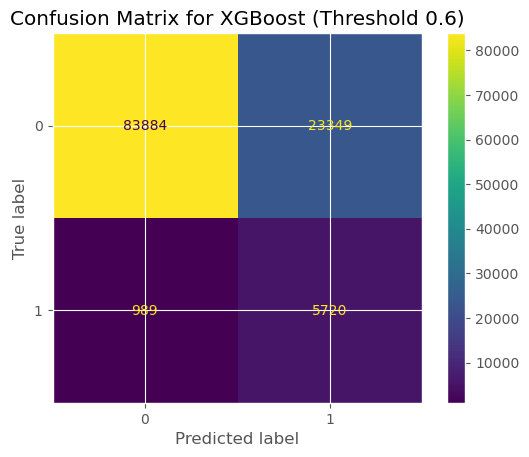

In [14]:
# Evaluate the models
for model_name, model in best_models.items():
    print(f"Evaluating {model_name}")
    
    # Get predictions and probabilities
    y_probs = model.predict_proba(X_test_scaled)[:, 1]
    y_pred = (y_probs >= 0.6).astype(int)  # Apply threshold of 0.6

    # Calculate and print Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Best {model_name} Accuracy: {accuracy}")

    # Calculate and print ROC-AUC
    roc_auc = roc_auc_score(y_test, y_probs)
    print(f"Best {model_name} ROC-AUC: {roc_auc}")

    # Print confusion matrix and classification report
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()
    plt.title(f"Confusion Matrix for {model_name} (Threshold 0.6)")
    plt.show()

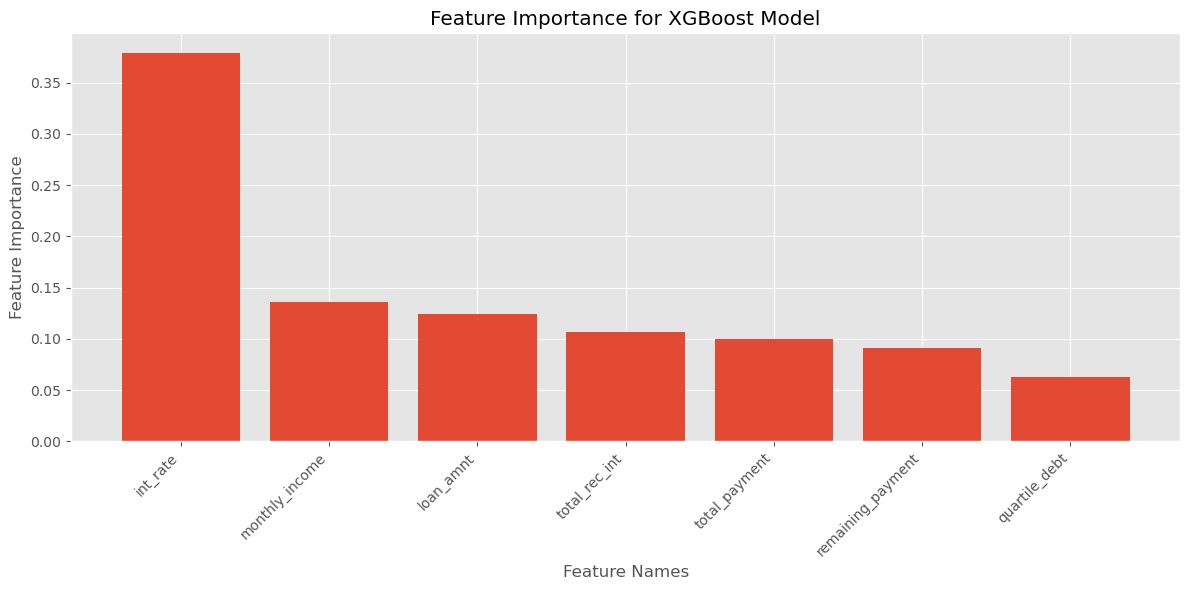

In [15]:
# Feature importance for XGBoost model
xgb_model = best_models["XGBoost"]
feature_importances = xgb_model.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(feature_importances)[::-1]  # Indices of features sorted in descending order

# Plot feature importance
plt.figure(figsize=(12, 6))
plt.bar(range(len(feature_importances)), feature_importances[indices], align="center")
plt.xticks(range(len(feature_importances)), [features[i] for i in indices], rotation=45, ha="right")
plt.xlabel("Feature Names")
plt.ylabel("Feature Importance")
plt.title("Feature Importance for XGBoost Model")
plt.tight_layout()
plt.show()

In [23]:
import pandas as pd

# Get probabilities
probabilities_xgb = xgb_model.predict_proba(X_test_scaled)


predictions_with_threshold = (probabilities_xgb[:, 1] >= 0.6).astype(int)

# Create a DataFrame to show probabilities and classifications
result_df = pd.DataFrame({
    'Probability_Class_1': probabilities_xgb[:, 1],  
    'Prediction': predictions_with_threshold,        
    'Risk_Category': pd.cut(
        probabilities_xgb[:, 1],
        bins=[0, 0.3, 0.7, 1],                      
        labels=['Low Risk', 'Medium Risk', 'High Risk']
    )
})

   Probability_Class_1  Prediction Risk_Category
0             0.548668           0   Medium Risk
1             0.306646           0   Medium Risk
2             0.805289           1     High Risk
3             0.929135           1     High Risk
4             0.123658           0      Low Risk


In [17]:
print(probabilities_xgb)

[[0.45133162 0.5486684 ]
 [0.6933536  0.3066464 ]
 [0.19471127 0.80528873]
 ...
 [0.376365   0.623635  ]
 [0.6133603  0.3866397 ]
 [0.09022653 0.90977347]]


In [18]:
risk_analysis = pd.DataFrame({
    'risk_score': probabilities_xgb[:, 1],  
    'risk_category': pd.cut(
        probabilities_xgb[:, 1],
        bins=[0, 0.3, 0.7, 1],
        labels=['Low Risk', 'Medium Risk', 'High Risk']
    )
})
print(risk_analysis)

        risk_score risk_category
0         0.548668   Medium Risk
1         0.306646   Medium Risk
2         0.805289     High Risk
3         0.929135     High Risk
4         0.123658      Low Risk
...            ...           ...
113937    0.380113   Medium Risk
113938    0.624993   Medium Risk
113939    0.623635   Medium Risk
113940    0.386640   Medium Risk
113941    0.909773     High Risk

[113942 rows x 2 columns]


In [20]:
X_test.to_csv('predicted_risk_analysis_final.csv', index=False)

In [21]:
X_test.shape

(113942, 9)

In [22]:
category_summary = X_test.groupby('risk_category').size()
print(category_summary)

risk_category
Low Risk       58660
Medium Risk    33495
High Risk      21787
dtype: int64


C:\Users\rizar\AppData\Local\Temp\ipykernel_31312\1161109068.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  category_summary = X_test.groupby('risk_category').size()
